In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

sys.path.append("../src/")
from sarra_py import *


In [2]:
# https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0
# cdsapi

In [3]:
grid_width = 1
grid_height = 1
duration = 365

In [4]:
from logging import exception


paramVariete = {

                # paramètres depuis Ag3 USA Hars v42_12_ p4 irr
                # # récupérés depuis HV42 parameters
                #variete mais iowa USA V42
                
                "SDJLevee":90, # OK
                "SDJBVP":320, # OK
                "SDJRPR":500, # OK
                "SDJMatu1":560, # OK
                "SDJMatu2":200, # OK
                
                "KRdtPotA": 0.8,  # OK
                "KRdtPotB": 200, # OK

                "PPExp" : 0, # OK
                "SeuilPP" : 13.6, # OK
                "PPsens" : 5, # OK
                "PPCrit": 11, # OK

                "TBase":8, # OK
                "TOpt1":26, # OK
                "TOpt2":34, # OK
                "TLim":44, # OK

                "pcReallocFeuille":0.7, # OK # partFeuilleTige
                'txConversion':5.8, # OK
                'txAssimBVP':1, # OK
                'txAssimMatu1':0.9, # OK
                'txAssimMatu2':0.1,  # OK

                "kRespMaint":0.01, # OK
                "aeroTotBase":0.6, # OK
                "aeroTotPente":5E-5, # OK
                "feuilAeroBase":0.55, # OK
                "feuilAeroPente":-5E-5, # OK

                "txRealloc":0.4, # OK #realloc
                "tempMaint":25, # OK
                "KRdtBiom":0, # OK
                
                "kcMax":1.25, # OK
                # "txRuSurfGermi":0.8,
                "PFactor":0.45, # OK
                "seuilCstrMortality":3, # OK

                'kdf': 0.4,  # OK
                "poidsSecGrain":0.38, # OK
                "txResGrain":0.55, # OK

                "VRacLevee":30.0, # OK
                "VRacBVP":15.0, # OK
                "VRacPSP":15.0, # OK
                "VRacRPR":15.0, # OK
                "VRacMatu1":12.0, # OK
                "VRacMatu2":12.0, # OK

                "slaMin":0.0016, # OK
                "slaMax":0.005, # OK
                "slaPente":0.4, # OK

                "phaseDevVeg":0, # OK
                "senCO2":10, # OK
                
                "densOpti":85000, # OK
                "densiteA":0.7, # OK
                "densiteP":4.5, # OK

                "NIYo":1,
                "NIp":0,
                "LGauss":1,
                "AGauss":1,

                #pas dans les params sarra-h
                # "kTempMaint":25, #remplacé par tempmaint
                # "slaBVP":0.003, #remplacé par slamin
                # "slaRPR":0.003, #remplacé par slamax
                # "KpenteSla":1, #remplacé par slaPente
                # "kBaseLaiDev":0.2, #remplacé par feuilAeroBase
                # "kPenteLaiDev":0.5, # remplacé par feuilAeroPente
                }

if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()



paramITK = {
            "DateSemis":datetime.date(2012,4,28), # OK
            "profRacIni":0,# OK
            "densite":86500, # OK
            "mulch":100,  # OK
            "seuilEauSemis":0, # OK
            "nbjTestSemis":0, # OK
            "irrigAuto":False, # OK
            "irrigAutoTarget":0, # OK
            "maxIrrig":0, # OK
            "precision":0, # OK
            "biomIniMc":0, # OK
            "humSatMc":0, # OK
            "surfMc":0, # OK
            "coefMc":0, # OK

            "KNUp":0, # OK
            "KNLit":0, # OK
            "KT":0, # OK
            "KI":0, # OK
            
            # non utilisés dans le modèle python
            "DisMc":000000, # OK
            "TxRecolte":0, # OK
            "TxaTerre":0, # OK
            "NbUBT":10, # OK
            
            # non présents dans sarra-h
            "dateFin":300,
            "NI":1, 

            
            
            }

paramTypeSol = {
                "stockIniSurf":30, # OK
                "stockIniProf":170, # OK
                "epaisseurSurf": 200, # OK
                "epaisseurProf" : 1300, # OK

                # params type sol
                "seuilRuiss":20, # OK
                "pourcRuiss":30/100, # OK
                "ru":132, # OK

                # non utilisés mais présents dans sarra-h
                "HumCR":0.32, # OK
                "HumPF":0.18, # OK
                'HumFC':0.32, # OK
                "HumSat":0.48, # OK
                "Pevap":0.2, # OK
                "PercolationMax":5, # OK

                }

# paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)


# ruRac = paramTypeSol["ru"] * paramITK["profRacIni"] / 1000 # alt name rRac
# ruSurf = paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

In [5]:
lat,long = 42.02, -93.75
date_start = datetime.date(2012,4,1)
duration = 250
 
 # getting weather data
weatherdata = NASAPowerWeatherDataProvider(longitude=long, latitude=lat)
print(weatherdata)
df_weather = pd.DataFrame(weatherdata.export())
df_weather = df_weather[(df_weather["DAY"]>=date_start) & (df_weather["DAY"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather.head()

df_weather["DOY"] = df_weather.apply(lambda x: x["DAY"].timetuple().tm_yday, axis=1)
df_weather["ET0"] = df_weather["ET0"] * 10 #conversion cm to mm

df_weather["RAIN"] = df_weather["RAIN"] * 10 #conversion cm to mm

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:  310.2
Latitude:  42.020
Longitude: -93.750
Data available for 1984-01-01 - 2022-07-27
Number of missing days: 2



In [6]:
# alt with loading exported data from sarra-h

#lat,long = 42.02, -93.75
elevation = 329

df_weather = pd.read_csv("../data/Meteorologie_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_rain = pd.read_csv("../data/Pluviometrie_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather[(df_weather["Jour"]>=date_start) & (df_weather["Jour"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)

df_weather = df_weather.rename(columns={"Pluie":"RAIN"})

In [7]:
"""def _estimate_AngstAB(self, df_power):
        Determine Angstrom A/B parameters from Top-of-Atmosphere (ALLSKY_TOA_SW_DWN) and
        top-of-Canopy (ALLSKY_SFC_SW_DWN) radiation values.
        :param df_power: dataframe with POWER data
        :return: tuple of Angstrom A/B values
        The Angstrom A/B parameters are determined by dividing swv_dwn by toa_dwn
        and taking the 0.05 percentile for Angstrom A and the 0.98 percentile for
        Angstrom A+B: toa_dwn*(A+B) approaches the upper envelope while
        toa_dwn*A approaches the lower envelope of the records of swv_dwn
        values.
        """

'def _estimate_AngstAB(self, df_power):\n        Determine Angstrom A/B parameters from Top-of-Atmosphere (ALLSKY_TOA_SW_DWN) and\n        top-of-Canopy (ALLSKY_SFC_SW_DWN) radiation values.\n        :param df_power: dataframe with POWER data\n        :return: tuple of Angstrom A/B values\n        The Angstrom A/B parameters are determined by dividing swv_dwn by toa_dwn\n        and taking the 0.05 percentile for Angstrom A and the 0.98 percentile for\n        Angstrom A+B: toa_dwn*(A+B) approaches the upper envelope while\n        toa_dwn*A approaches the lower envelope of the records of swv_dwn\n        values.\n        '

In [8]:
a, b = 17.625, 243.04
df_weather["TMoy"] = ((df_weather["TMin"]+df_weather["TMax"])/2) # + 273.15
# calcul du point de rosée d'après https://www.omnicalculator.com/physics/dew-point
df_weather["PointRosee"] = (b * np.log(df_weather["HMoy"]/100) + a*df_weather["TMoy"]/(b+df_weather["TMoy"])) / (a - np.log(df_weather["HMoy"]/100) + a*df_weather["TMoy"]/(b+df_weather["TMoy"]))
# alternative https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html
df_weather["PointRosee2"] = df_weather["TMoy"] - ((100 - df_weather["HMoy"])/5)

# calcul de la pression de vapeur d'après https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
# rh = e/es * 100
# e = rh/100 * es
df_weather["VapourPressure"] = df_weather["HMoy"]/100 * 6.11 * 10**(7.5*df_weather["TMoy"]/(237.3+df_weather["TMoy"]))
df_weather["VapourPressure2"] = 6.11 * 10**((7.5*df_weather["PointRosee"])/(237.3+df_weather["PointRosee"]))
df_weather["VapourPressure3"] = 6.11 * 10**((7.5*df_weather["PointRosee2"])/(237.3+df_weather["PointRosee2"]))

In [9]:
# angstA et B d'après nasa power
angstA = 0.29
angstB = 0.49
df_weather["ET0"] = df_weather.apply(lambda x: reference_ET(x["Jour"], lat, elevation, x["TMin"] , x["TMax"], x["Rg"]*1E6, x["VapourPressure"], x["Vt"], angstA, angstB, ETMODEL="PM")[2], axis=1)

In [10]:
df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

In [11]:
df_irrig = pd.read_csv("../data/Irrigation_AG3US20124.txt", sep="\t", decimal=",", skiprows=1)
df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

ordre des modules depuis SarrahV42.docx

In [12]:
def EvalPar(data):
    #depuis meteo.par
    kpar = 0.5
    data["par"] = kpar * data["rg"]
    return data

# Run

In [13]:
data = {}

data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK

data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK)
data = EvalPar(data)


for j in range(duration):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python

    
    
    print("\n cycle",j)

    if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK
        
    #bilan hydrique
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    # data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    # data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2


        



     


 cycle 0
lai 1 [[0.]]
NI NOT NULL
assim 1 [[0.]]
biomasseTotale 2 [[0.]]
test biomasseTotale [[False]]
biomasseTotale 3 [[0.]]
biomasseTotale 4 [[0.]]
biomasseTotale 5 [[0.]]
biomasseTotale 6 [[0.]]
biomasseAerienne 1 [[0.]]
biomasseTotale 7 [[0.]]
condition 1 [[False]]
biomasseFeuille 1 [[0.]]
condition 2 [[False]]
condition biomasseFeuille 2 [[False]]
biomasseFeuille 2 [[0.]]
biomasseFeuille 3 [[0.]]
biomasseAerienne 2 [[0.]]
sla 1 [[0.]]
sla 2 [[0.]]
sla 3 [[0.]]
lai 2 [[0.]]

 cycle 1
lai 1 [[0.]]
NI NOT NULL
assim 1 [[0.]]
biomasseTotale 2 [[0.]]
test biomasseTotale [[False]]
biomasseTotale 3 [[0.]]
biomasseTotale 4 [[0.]]
biomasseTotale 5 [[0.]]
biomasseTotale 6 [[0.]]
biomasseAerienne 1 [[0.]]
biomasseTotale 7 [[0.]]
condition 1 [[False]]
biomasseFeuille 1 [[0.]]
condition 2 [[False]]
condition biomasseFeuille 2 [[False]]
biomasseFeuille 2 [[0.]]
biomasseFeuille 3 [[0.]]
biomasseAerienne 2 [[0.]]
sla 1 [[0.]]
sla 2 [[0.]]
sla 3 [[0.]]
lai 2 [[0.]]

 cycle 2
lai 1 [[0.]]
NI NOT 

/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:168: RuntimeWarning: invalid value encountered in divide
  (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"])
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:491: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j]/data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:735: RuntimeWarning: invalid value encountered in divide
  (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:787: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j] / data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:916: RuntimeWarning: invalid value encountered in divide
  np.maximum(data["stRuSurf"][:,:,j] - (data["tr"][:,:,j] * np.minimum(data["trSurf"][:,:,j]/data["stRur"][:,:

lai 1 [[0.02132369]]
NI NOT NULL
assim 1 [[0.68405738]]
biomasseTotale 2 [[38.67900423]]
test biomasseTotale [[False]]
biomasseTotale 3 [[39.3630616]]
biomasseTotale 4 [[39.3630616]]
biomasseTotale 5 [[39.3630616]]
biomasseTotale 6 [[39.3630616]]
biomasseAerienne 1 [[23.69530949]]
biomasseTotale 7 [[39.3630616]]
condition 1 [[False]]
biomasseFeuille 1 [[12.77733158]]
condition 2 [[ True]]
condition biomasseFeuille 2 [[ True]]
biomasseFeuille 2 [[13.00354108]]
biomasseFeuille 3 [[13.00354108]]
biomasseAerienne 2 [[23.69530949]]
sla 1 [[0.00166887]]
sla 2 [[0.00167077]]
sla 3 [[0.00167077]]
lai 2 [[0.02172599]]

 cycle 95
lai 1 [[0.02172599]]
NI NOT NULL
assim 1 [[0.53308179]]
biomasseTotale 2 [[39.3630616]]
test biomasseTotale [[False]]
biomasseTotale 3 [[39.89614339]]
biomasseTotale 4 [[39.89614339]]
biomasseTotale 5 [[39.89614339]]
biomasseTotale 6 [[39.89614339]]
biomasseAerienne 1 [[24.01727115]]
biomasseTotale 7 [[39.89614339]]
condition 1 [[False]]
biomasseFeuille 1 [[13.00354108]

In [14]:
2**3

8

In [15]:
2*np.exp(2)

14.7781121978613

In [16]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
for variable in list(data) :
    print(variable)
    try:
        plt.plot(df_weather["Jour"], data[variable][0,0,:])
        plt.title(variable)
        plt.xticks(rotation=45)
        plt.show()
    except:
        pass

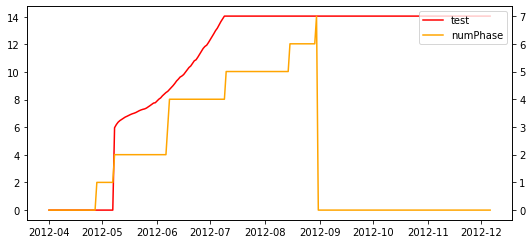

In [21]:
data["test"] = data["biomasseFeuille"] 

variable1="test"
variable2="numPhase"

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot()
l1, = ax1.plot(df_weather["Jour"], data[variable1][0,0,:], color='red')

ax2 = ax1.twinx()
l2, = ax2.plot(df_weather["Jour"], data[variable2][0,0,:], color='orange')

plt.legend([l1, l2], [variable1, variable2])
plt.xticks(rotation=45)
plt.show()

In [ ]:
paramITK["densite"]

86500